In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [5]:
import sys
sys.path.append('/content/drive/MyDrive/EMIP-Toolkit')
sys.path.append('/content/drive/MyDrive/EMIP-Toolkit/emtk')
sys.path.append('/content/drive/MyDrive/EMIO-Toolkit/emtk/parsers')
print(sys.path)

['/content', '/env/python', '/usr/lib/python311.zip', '/usr/lib/python3.11', '/usr/lib/python3.11/lib-dynload', '', '/usr/local/lib/python3.11/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.11/dist-packages/IPython/extensions', '/root/.ipython', '/content/drive/MyDrive/EMIP-Toolkit', '/content/drive/MyDrive/EMIP-Toolkit/emtk', '/content/drive/MyDrive/EMIO-Toolkit/emtk/parsers']


In [6]:
import parsers
import aoi
import visualization
import util

#Downgrade Pandas and Numpy

In [6]:
!pip uninstall pandas -y
!pip install pandas==1.5.3

Found existing installation: pandas 2.2.2
Uninstalling pandas-2.2.2:
  Successfully uninstalled pandas-2.2.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 65.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 1.5.3 which is incompatible.
geopandas 1.1.1 requires pandas>=2.0.0, but you have pandas 1.5.3 which is incompatible.
mizani 0.13.5 requires pandas>=2.2.0, but you have pandas 1.5.3 which is incompatible.
xarray 2025.7.1 requires pandas>=2.2, but you have pandas 1.5.3 which is incompatible.
dask-cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 1.5.3 which is incompatible.
arviz 0.22.0 requires pandas>=2.1.0, but you have pandas 1.5.3 which is incompatible.
plotnine 0.14.5 requires pandas>=2.2.0, but you have pandas 1.5.3 which is incompatible.
cud

In [4]:
!pip uninstall numpy -y
!pip install numpy==1.25.2

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 70.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 1.5.3 which is incompatible.
geopandas 1.1.1 requires pandas>=2.0.0, but you have pandas 1.5.3 which is incompatible.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 1.25.2 which is incompatible.
mizani 0.13.5 requires pandas>=2.2.0, but you have pandas 1.5.3 which is incompatible.
blosc2 3.6.1 requires numpy>=1.26, but you have numpy 1.25.2 which is incompatible.
xarray 2025.7.1 requires numpy>=1.26, but you have numpy 1.25.2 which is incompatible.
xarray 2025.7.1 requires pandas>=2.2, but you have pandas 1.5.3 which is incompatible.
dask-cudf-cu12 2

# Parsing raw data from the EMIP dataset

In [7]:
import pandas as pd
import os

desired_path = '/content/drive/MyDrive/EMIP-Toolkit/emtk/parsers'

os.chdir(desired_path)
print(os.getcwd())

from eye_events import eye_event_list, get_eye_event_columns
from samples import get_samples_columns, samples_list

from emtk.fixation_classification import idt_classifier

/content/drive/MyDrive/EMIP-Toolkit/emtk/parsers


In [8]:


# Replace this path with your desired directory
#desired_path = '/content/drive/MyDrive/EMIP-Toolkit'
desired_path = os.path.join(
    '/content/drive/MyDrive/EMIP-Toolkit/emtk/datasets/EMIP',
    'EMIP-Toolkit- replication package',
    'emip_dataset'
)

os.chdir(desired_path)
print(os.getcwd())

entries = os.listdir(os.getcwd())
print(entries)



/content/drive/MyDrive/EMIP-Toolkit/emtk/datasets/EMIP/EMIP-Toolkit- replication package/emip_dataset
['date.txt', 'emip_metadata.csv', 'stimuli', 'rawdata', 'EMIP_DataCollection_Materials']


## Read gender from the metadata file


In [9]:
# Load metadata
#METADATA_FILE = '/emtk/datasets/EMIP/EMIP-Toolkit- replication package/emip_dataset/emip_metadata.csv'
METADATA_FILE = 'emip_metadata.csv'
try:
    metadata_df = pd.read_csv(METADATA_FILE)
    print(f"Loaded metadata for {len(metadata_df)} participants")

    # Create a mapping from participant ID to gender
    # Assuming 'id' column in metadata corresponds to experiment_id/participant_id
    gender_mapping = dict(zip(metadata_df['id'].astype(str), metadata_df['gender']))
    print(f"Gender mapping created for {len(gender_mapping)} participants")

except FileNotFoundError:
    print(f"Warning: Metadata file '{METADATA_FILE}' not found. Gender will be set to Male.")
    gender_mapping = {}
except Exception as e:
    print(f"Error loading metadata: {e}. Gender will be set to Male.")
    gender_mapping = {}

Loaded metadata for 216 participants
Gender mapping created for 216 participants


In [10]:
# Replace this path with your desired directory
desired_path = '/content/drive/MyDrive/EMIP-Toolkit'


os.chdir(desired_path)
print(os.getcwd())

#entries = os.listdir(os.getcwd())
#print(entries)

/content/drive/MyDrive/EMIP-Toolkit


In [14]:
RAWDATA_MODULE = "emtk/datasets/EMIP/EMIP-Toolkit- replication package/emip_dataset/rawdata"

SAMPLE_BASE_COLUMNS = ['Time', 'Type', 'Trial', 'L Raw X [px]', 'L Raw Y [px]', 'R Raw X [px]',
                       'R Raw Y [px]', 'L Dia X [px]', 'L Dia Y [px]', 'L Mapped Diameter [mm]',
                       'R Dia X [px]', 'R Dia Y [px]', 'R Mapped Diameter [mm]', 'L CR1 X [px]',
                       'L CR1 Y [px]', 'L CR2 X [px]', 'L CR2 Y [px]', 'R CR1 X [px]', 'R CR1 Y [px]',
                       'R CR2 X [px]', 'R CR2 Y [px]', 'L POR X [px]', 'L POR Y [px]', 'R POR X [px]',
                       'R POR Y [px]', 'Timing', 'L Validity', 'R Validity', 'Pupil Confidence',
                       'L Plane', 'R Plane', 'L EPOS X', 'L EPOS Y', 'L EPOS Z', 'R EPOS X', 'R EPOS Y',
                       'R EPOS Z', 'L GVEC X', 'L GVEC Y', 'L GVEC Z', 'R GVEC X', 'R GVEC Y',
                       'R GVEC Z', 'Frame', 'Aux1']

def EMIP(sample_size: int = 216):
    """Import the EMIP dataset.

    Parameters
    ----------
    sample_size : int, optional (default 216)
        Number of subjects to be processed.

    Returns
    -------
    pandas.DataFrame
        Pandas dataframe of eye events from every experiment in the dataset.
    """
    eye_events = []
    samples = []
    parsed_experiments = []

    # go over .tsv files in the rawdata directory add files and count them
    # r = root, d = directories, f = files
    for r, _, f in os.walk(RAWDATA_MODULE):
        f = [name for name in f if name and name[0].isdigit()]
        print(len(f))
        #f.sort()
        f.sort(key=lambda name: int(name.split('_')[0]))
        for file in f:
            if '.tsv' in file:
                experiment_id = file.split('/')[-1].split('_')[0]

                if experiment_id not in parsed_experiments:
                    parsed_experiments.append(experiment_id)

                    #Get gender for this participant
                    participant_gender = gender_mapping.get(experiment_id, None)
                    if participant_gender is None:
                        print(f"Warning: No gender data found for participant {experiment_id}")
                        participant_gender = "male"
                    else:
                        print(f"Gender for participant {experiment_id}: {participant_gender}")


                    new_eye_events, new_samples = read_SMIRed250(
                        root_dir=r,
                        filename=file,
                        experiment_id=experiment_id,
                        gender = participant_gender
                    )

                    eye_events.extend(new_eye_events)
                    samples.extend(new_samples)

                else:
                    print("Error, experiment already in dictionary")

            sample_size -= 1
            if sample_size == 0:
                break

    eye_events_df = pd.DataFrame(eye_events, columns=get_eye_event_columns())

    # Convert columns with numbers formatted as strings to dtype of numeric
    samples_df = pd.DataFrame(
        samples, columns=get_samples_columns(SAMPLE_BASE_COLUMNS))
    id_dfs = samples_df[["experiment_id", "participant_id", "trial_id"]]
    samples_df = samples_df.apply(pd.to_numeric, errors='ignore')
    samples_df[id_dfs.columns] = id_dfs

    return eye_events_df, samples_df

In [15]:
EYE_TRACKER = "SMIRed250"
FILE_TYPE = ".tsv"
STIMULI_MODULE = "emtk/datasets/EMIP/EMIP-Toolkit- replication package/emip_dataset/stimuli"

def read_SMIRed250(root_dir, filename, experiment_id,
                   minimum_duration=50, sample_duration=4, maximum_dispersion=25, gender = None) -> list:
    """Read tsv file from SMI Red 250 eye tracker

    Parameters
    ----------
    root_dir : str
        Path to directory that contains the asc file.

    filename : str
        Name of asc file.

    experiment_id : str
        Id of the experiment contained in the file.

    Returns
    -------
    list
        List of eye events. Each eye event is represented as a list of eye event features.
    """

    # Reads raw data and sets up
    tsv_file = open(os.path.join(root_dir, filename))
    #print(filename)
    print("parsing file:", filename.split("/")[-1])
    text = tsv_file.read()
    text_lines = text.split('\n')

    trial_id = 0
    stimuli_name = ""
    raw_fixations = []
    active = False  # Indicates whether samples are being recorded in trials
    # The goal is to skip metadata in the file

    eye_events = []
    samples = []

    # Parses the data into dataframes
    for line in text_lines:
        token = line.split("\t")

        if len(token) < 3:
            continue

        if active:
            # Filter MSG samples if any exist, or R eye is inValid
            if token[1] == "SMP" and token[27] != "-1":
                # Get x and y for each sample (right eye only)
                # [23] R POR X [px]	 '0.00',
                # [24] R POR Y [px]	 '0.00',

                new_sample = samples_list(
                    eye_tracker=EYE_TRACKER,
                    experiment_id=experiment_id,
                    participant_id=experiment_id,
                    filename=filename,
                    trial_id=str(trial_id),
                    stimuli_module=STIMULI_MODULE,
                    stimuli_name=stimuli_name,
                    token=token,
                    gender = gender
                )

                samples.append(new_sample)

                raw_fixations.append(
                    [int(token[0]), float(token[23]), float(token[24])])

        if token[1] == "MSG" and token[3].find(".jpg") != -1:

            if active:
                filter_eye_events = idt_classifier(raw_fixations=raw_fixations,
                                                   minimum_duration=minimum_duration,
                                                   sample_duration=sample_duration,
                                                   maximum_dispersion=maximum_dispersion)
                # TODO saccades

                for timestamp, duration, x_cord, y_cord in filter_eye_events:

                    new_eye_event = eye_event_list(eye_tracker=EYE_TRACKER,
                                                   experiment_id=experiment_id,
                                                   participant_id=experiment_id,
                                                   filename=filename,
                                                   trial_id=str(trial_id),
                                                   stimuli_module=STIMULI_MODULE,
                                                   stimuli_name=stimuli_name,
                                                   duration=duration,
                                                   timestamp=timestamp,
                                                   x0=x_cord,
                                                   y0=y_cord,
                                                   token=token,
                                                   pupil=0,
                                                   eye_event_type="fixation",
                                                   gender = gender)

                    eye_events.append(new_eye_event)

                trial_id += 1

            # Message: vehicle_java2.jpg
            stimuli_name = token[3].split(' ')[-1]
            raw_fixations = []
            active = True

    # Adds the last trial
    filter_fixations = idt_classifier(raw_fixations=raw_fixations,
                                      minimum_duration=minimum_duration,
                                      sample_duration=sample_duration,
                                      maximum_dispersion=maximum_dispersion)

    for timestamp, duration, x_cord, y_cord in filter_fixations:

        new_eye_event = eye_event_list(eye_tracker=EYE_TRACKER,
                                       experiment_id=experiment_id,
                                       participant_id=experiment_id,
                                       filename=filename,
                                       trial_id=str(trial_id),
                                       stimuli_module=STIMULI_MODULE,
                                       stimuli_name=stimuli_name,
                                       duration=duration,
                                       timestamp=timestamp,
                                       x0=x_cord,
                                       y0=y_cord,
                                       token=token,
                                       pupil=0,
                                       eye_event_type="fixation",
                                       gender = gender)

        eye_events.append(new_eye_event)

    return eye_events, samples

In [16]:
eye_events, samples = EMIP(sample_size = 10)

216
Gender for participant 1: male
parsing file: 1_rawdata.tsv
Gender for participant 2: male
parsing file: 2_rawdata.tsv
Gender for participant 3: female
parsing file: 3_rawdata.tsv
Gender for participant 4: male
parsing file: 4_rawdata.tsv
Gender for participant 5: male
parsing file: 5_rawdata.tsv
Gender for participant 6: male
parsing file: 6_rawdata.tsv
Gender for participant 7: male
parsing file: 7_rawdata.tsv
Gender for participant 8: female
parsing file: 8_rawdata.tsv
Gender for participant 9: male
parsing file: 9_rawdata.tsv
Gender for participant 10: male
parsing file: 10_rawdata.tsv


In [21]:
samples.head()



,eye_tracker,experiment_id,participant_id,filename,trial_id,stimuli_module,stimuli_name,gender,Time,Type,...,R EPOS Y,R EPOS Z,L GVEC X,L GVEC Y,L GVEC Z,R GVEC X,R GVEC Y,R GVEC Z,Frame,Aux1
0,SMIRed250,100,100,100_rawdata.tsv,0,emtk/datasets/EMIP/EMIP-Toolkit- replication p...,instruction_calibration.jpg,male,20521593840,SMP,...,0.0,0.0,-0.15,0.08,-0.99,0.0,0.0,0.0,-1,NaN
1,SMIRed250,100,100,100_rawdata.tsv,0,emtk/datasets/EMIP/EMIP-Toolkit- replication p...,instruction_calibration.jpg,male,20521597841,SMP,...,0.0,0.0,-0.14,0.08,-0.99,0.0,0.0,0.0,-1,NaN
2,SMIRed250,100,100,100_rawdata.tsv,0,emtk/datasets/EMIP/EMIP-Toolkit- replication p...,instruction_calibration.jpg,male,20521601842,SMP,...,0.0,0.0,-0.15,0.07,-0.99,0.0,0.0,0.0,-1,NaN
3,SMIRed250,100,100,100_rawdata.tsv,0,emtk/datasets/EMIP/EMIP-Toolkit- replication p...,instruction_calibration.jpg,male,20521605843,SMP,...,0.0,0.0,-0.15,0.08,-0.99,0.0,0.0,0.0,-1,NaN
4,SMIRed250,100,100,100_rawdata.tsv,0,emtk/datasets/EMIP/EMIP-Toolkit- replication p...,instruction_calibration.jpg,male,20521609844,SMP,...,0.0,0.0,-0.15,0.08,-0.99,0.0,0.0,0.0,-1,NaN


In [22]:
eye_events.head()

,eye_tracker,experiment_id,participant_id,filename,trial_id,stimuli_module,stimuli_name,timestamp,duration,x0,y0,x1,y1,token,pupil,amplitude,peak_velocity,eye_event_type,gender
0,SMIRed250,100,100,100_rawdata.tsv,0,emtk/datasets/EMIP/EMIP-Toolkit- replication p...,instruction_calibration.jpg,20521737835,144,627.440833,659.305000,NaN,NaN,"[20602727206, MSG, 1, # Message: instruction_c...",0,NaN,NaN,fixation,male
1,SMIRed250,100,100,100_rawdata.tsv,0,emtk/datasets/EMIP/EMIP-Toolkit- replication p...,instruction_calibration.jpg,20521797815,56,621.782857,653.210714,NaN,NaN,"[20602727206, MSG, 1, # Message: instruction_c...",0,NaN,NaN,fixation,male
2,SMIRed250,100,100,100_rawdata.tsv,0,emtk/datasets/EMIP/EMIP-Toolkit- replication p...,instruction_calibration.jpg,20521929711,112,665.515000,695.657500,NaN,NaN,"[20602727206, MSG, 1, # Message: instruction_c...",0,NaN,NaN,fixation,male
3,SMIRed250,100,100,100_rawdata.tsv,0,emtk/datasets/EMIP/EMIP-Toolkit- replication p...,instruction_calibration.jpg,20522125575,112,876.265000,692.520714,NaN,NaN,"[20602727206, MSG, 1, # Message: instruction_c...",0,NaN,NaN,fixation,male
4,SMIRed250,100,100,100_rawdata.tsv,0,emtk/datasets/EMIP/EMIP-Toolkit- replication p...,instruction_calibration.jpg,20522325667,116,1022.013103,671.194483,NaN,NaN,"[20602727206, MSG, 1, # Message: instruction_c...",0,NaN,NaN,fixation,male


# Visualization

In [ ]:
experiment_id = '100'
trial_id = '0'

if eye_events.empty and samples.empty:
  print('Both eye_events and samples dataframes are empty')
else:
  print('Both eye_events and samples dataframes are not empty')

Both eye_events and samples dataframes are not empty


#Raw data (samples), filtered fixations, saccades, and aoi

/content/drive/MyDrive/EMIP-Toolkit/emtk/aoi/find_aoi.py:171: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  aoi = aoi.append(dic, ignore_index=True)
/content/drive/MyDrive/EMIP-Toolkit/emtk/aoi/find_aoi.py:171: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  aoi = aoi.append(dic, ignore_index=True)
/content/drive/MyDrive/EMIP-Toolkit/emtk/aoi/find_aoi.py:171: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  aoi = aoi.append(dic, ignore_index=True)
/content/drive/MyDrive/EMIP-Toolkit/emtk/aoi/find_aoi.py:171: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  aoi = aoi.append(dic, ignore_index=True)
/content/drive/MyDrive/EMIP-Toolkit/emtk/aoi/fin

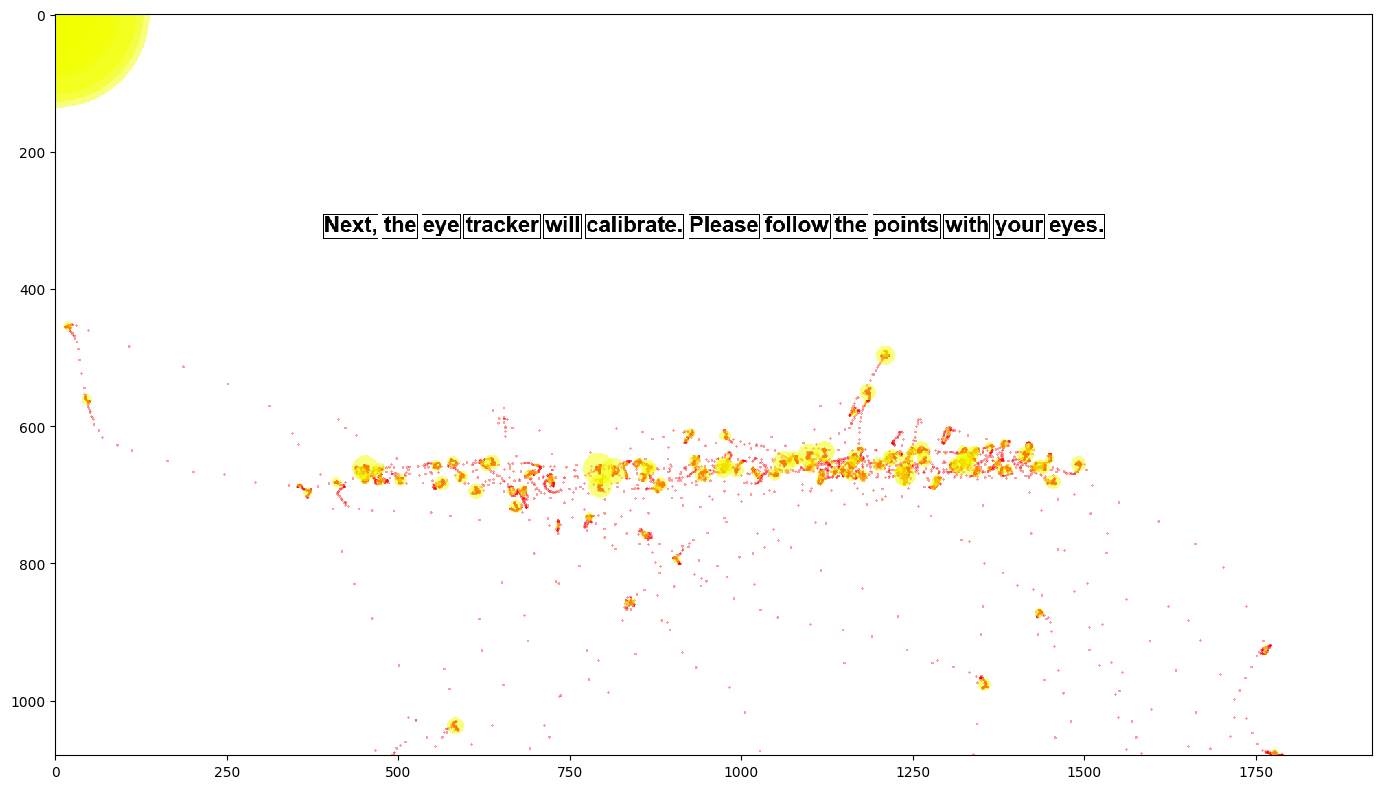

In [ ]:
trial_data = eye_events.loc[(eye_events['experiment_id'] == experiment_id) &
                            (eye_events['trial_id'] == trial_id)]

samples_data = samples.loc[(samples['experiment_id'] == experiment_id) &
                            (samples['trial_id'] == trial_id)]

visualization.draw_trial(trial_data, samples_data, draw_raw_data = True, draw_aoi = True, draw_saccade=True, sample_x_col="R POR X [px]", sample_y_col="R POR Y [px]")

/content/drive/MyDrive/EMIP-Toolkit/emtk/visualization/heatmap.py:62: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(ax=ax, x=x_cords, y=y_cords,


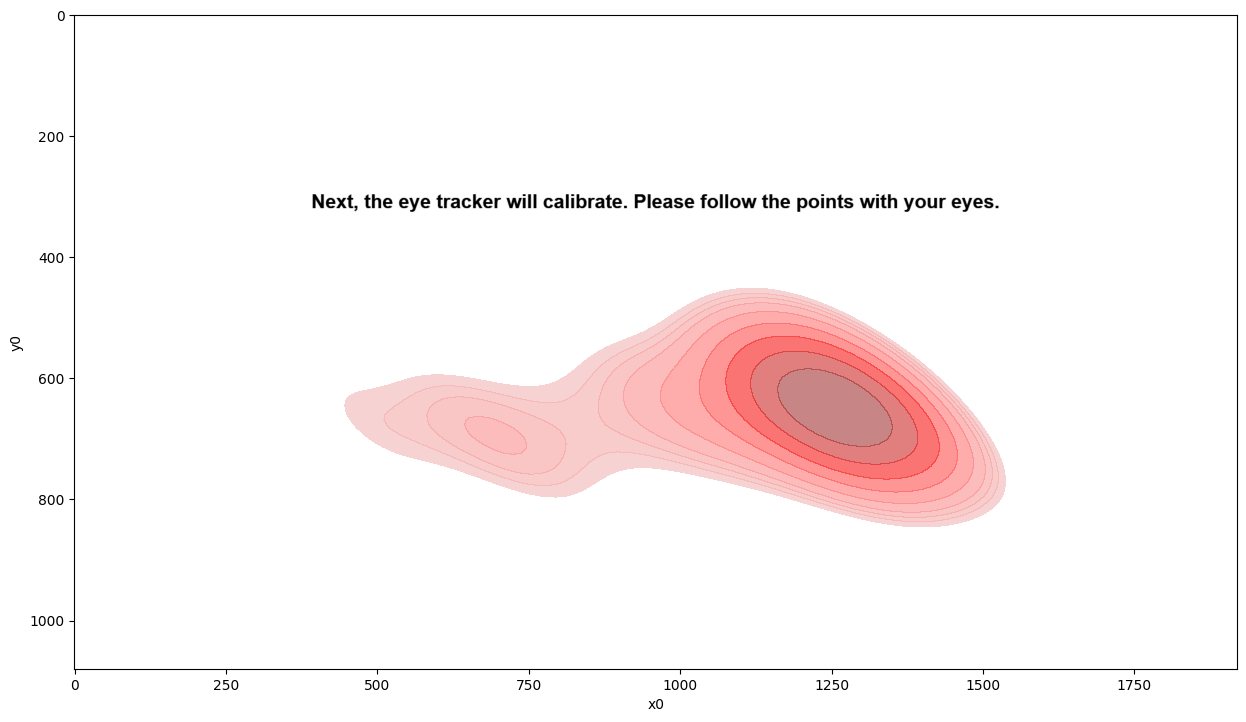

In [ ]:
visualization.heatmap(trial_data)

/content/drive/MyDrive/EMIP-Toolkit/emtk/aoi/find_aoi.py:171: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  aoi = aoi.append(dic, ignore_index=True)
/content/drive/MyDrive/EMIP-Toolkit/emtk/aoi/find_aoi.py:171: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  aoi = aoi.append(dic, ignore_index=True)
/content/drive/MyDrive/EMIP-Toolkit/emtk/aoi/find_aoi.py:171: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  aoi = aoi.append(dic, ignore_index=True)
/content/drive/MyDrive/EMIP-Toolkit/emtk/aoi/find_aoi.py:171: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  aoi = aoi.append(dic, ignore_index=True)
/content/drive/MyDrive/EMIP-Toolkit/emtk/aoi/fin

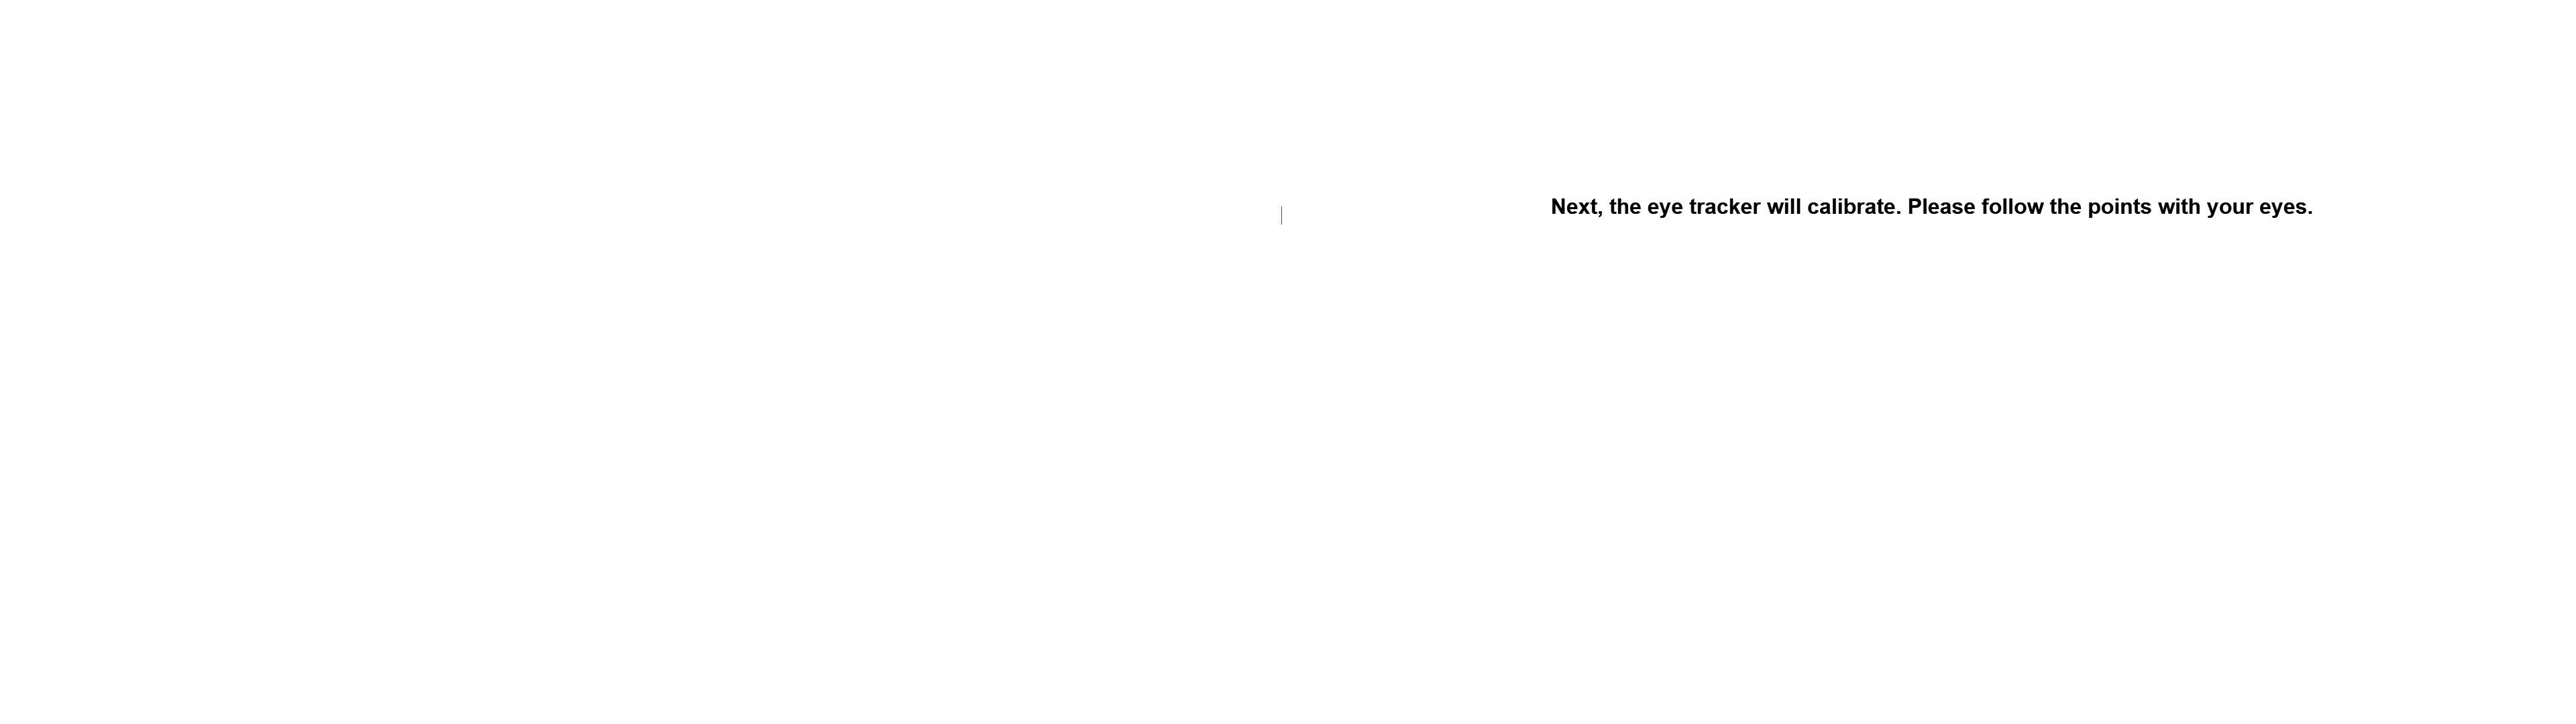

In [ ]:
visualization.fixation_duration(trial_data)